In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image
print("importing is finished")

importing is finished


In [7]:
breast_img = glob.glob('dataset/*/*/*.png', recursive = True)

In [28]:
len(breast_img)

277524

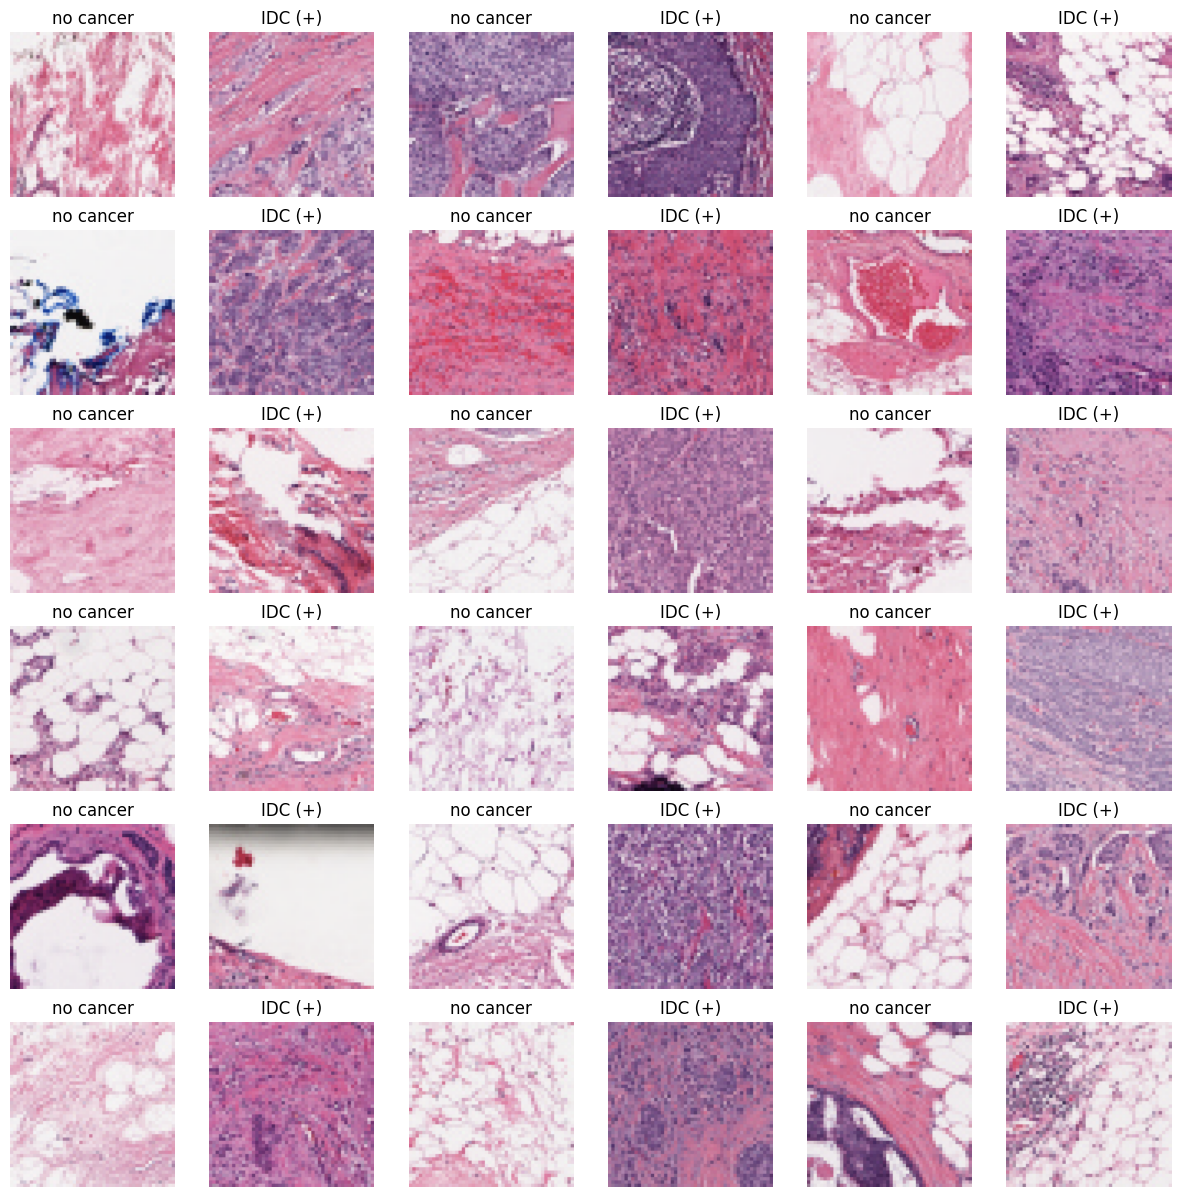

In [ ]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)
    
    elif img[-5] == '1' :
        P_IDC.append(img)
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    
        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:
    
        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img) 
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

In [13]:
NewN_IDC=N_IDC[:78786]
print(len(NewN_IDC))
print(len(P_IDC))

78786
78786


In [14]:
non_img_arr = []
can_img_arr = []

for img in NewN_IDC:
        
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])
    
for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

In [15]:
total = len(N_IDC) + len(P_IDC)
ppos = len(P_IDC)/total
desired = 40000
psamp = desired/total
print(total, ppos, desired, psamp)

non_img_arr = []
can_img_arr = []
non_y = []
can_y = []

for i,img in enumerate(N_IDC):
    if (np.random.uniform() < psamp):
      n_img = cv2.imread(img, cv2.IMREAD_COLOR)
      n_img = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
      non_img_arr.append(n_img)
      non_y.append(0)

for i,img in enumerate(P_IDC):
    if (np.random.uniform() < psamp):
      c_img = cv2.imread(img, cv2.IMREAD_COLOR)
      c_img = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
      can_img_arr.append(c_img)
      can_y.append(1)

X = np.concatenate((non_img_arr, can_img_arr))
y = np.concatenate([non_y,can_y])

print(":finished")

277524 0.28388896095472826 40000 0.14413167870166183
:finished


In [16]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,y)

Total number of images: 39979
Number of IDC(-) Images: 28733
Number of IDC(+) Images: 11246
Image shape (Width, Height, Channels): (50, 50, 3)


In [32]:
from sklearn.model_selection import train_test_split

# Premier split train / temp (train 70%, temp 30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
# Deuxième split temp en val / test (chacun 15% du total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [33]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

def as_tensor_img(X):
    # (N, H, W, C) → (N, C, H, W)
    return torch.tensor(X).permute(0, 3, 1, 2).float()

def as_tensor_lbl(y):
    if y.ndim > 1:
        y = np.argmax(y, axis=1)
    return torch.tensor(y).long()

X_train_torch = as_tensor_img(X_train)
X_val_torch   = as_tensor_img(X_val)
X_test_torch  = as_tensor_img(X_test)
y_train_torch = as_tensor_lbl(y_train)
y_val_torch   = as_tensor_lbl(y_val)
y_test_torch  = as_tensor_lbl(y_test)


In [34]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset   = TensorDataset(X_val_torch,   y_val_torch)
test_dataset  = TensorDataset(X_test_torch,  y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),        # 50x50x3 → 50x50x32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),       # 50x50x32
            nn.ReLU(),
            nn.MaxPool2d(2),                                   # 25x25x32
            nn.BatchNorm2d(32),
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),       # 25x25x64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),       # 25x25x64
            nn.ReLU(),
            nn.MaxPool2d(2),                                   # 12x12x64
            nn.BatchNorm2d(64),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),      # 12x12x128
            nn.ReLU(),
            nn.MaxPool2d(2),                                   # 6x6x128
            nn.BatchNorm2d(128),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6 * 6 * 128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [37]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='best_model.pth'):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


Epoch 1: Train Loss=0.4172, Val Loss=0.4440, Train AUC=0.8632, Val AUC=0.8561
Epoch 2: Train Loss=0.3832, Val Loss=0.3412, Train AUC=0.8841, Val AUC=0.9087
Epoch 3: Train Loss=0.3729, Val Loss=0.3370, Train AUC=0.8917, Val AUC=0.9128
Epoch 4: Train Loss=0.3647, Val Loss=0.4472, Train AUC=0.8973, Val AUC=0.9112
Epoch 5: Train Loss=0.3615, Val Loss=0.3530, Train AUC=0.8995, Val AUC=0.9156
Epoch 6: Train Loss=0.3530, Val Loss=0.3498, Train AUC=0.9040, Val AUC=0.9230
Epoch 7: Train Loss=0.3497, Val Loss=0.3280, Train AUC=0.9063, Val AUC=0.9215
Epoch 8: Train Loss=0.3432, Val Loss=0.3446, Train AUC=0.9095, Val AUC=0.9252
Epoch 9: Train Loss=0.3379, Val Loss=0.3092, Train AUC=0.9129, Val AUC=0.9280
Epoch 10: Train Loss=0.3329, Val Loss=0.3165, Train AUC=0.9155, Val AUC=0.9279
Epoch 11: Train Loss=0.3309, Val Loss=0.3057, Train AUC=0.9165, Val AUC=0.9294
Epoch 12: Train Loss=0.3234, Val Loss=0.4901, Train AUC=0.9199, Val AUC=0.9183
Epoch 13: Train Loss=0.3163, Val Loss=0.4441, Train AUC=0.923

C:\Users\SEBEOGO Landry Yves\AppData\Local\Temp\ipykernel_25208\3852724698.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

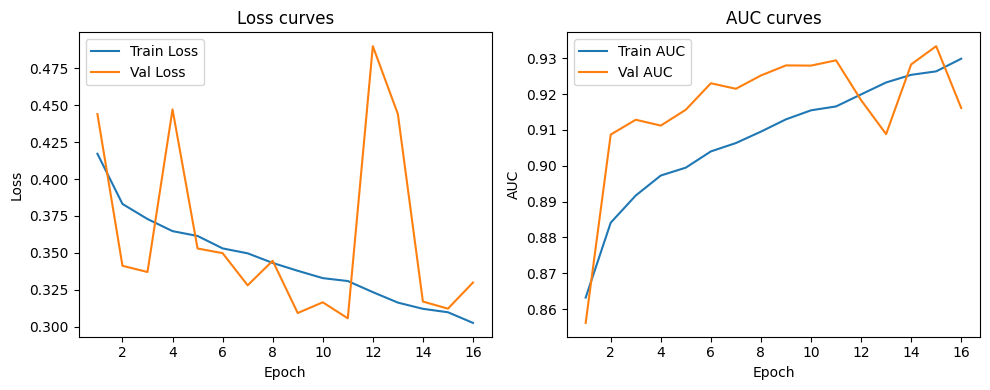

Confusion Matrix (Validation):


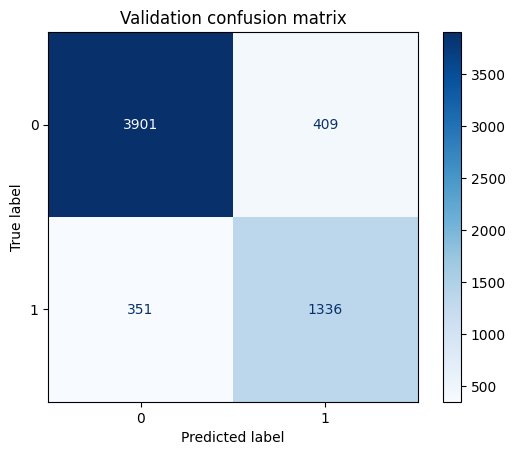

Confusion Matrix (Test):


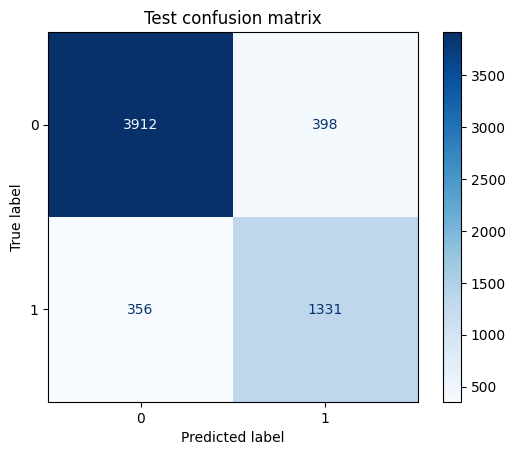

In [39]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

epochs = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNClassifier(num_classes=2).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
early_stopper = EarlyStopping(patience=5, path='best_model.pth')

history = {'loss': [], 'val_loss': [], 'auc_train': [], 'auc_val': []}

for epoch in range(epochs):
    # --- TRAIN ---
    model.train()
    train_loss = 0
    y_true_train = []
    y_pred_train = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
        y_true_train.append(y_batch.cpu().numpy())
        y_pred_train.append(F.softmax(outputs, 1)[:, 1].detach().cpu().numpy())
    train_loss /= len(train_loader.dataset)
    y_true_train = np.concatenate(y_true_train)
    y_pred_train = np.concatenate(y_pred_train)
    try:
        auc_train = roc_auc_score(y_true_train, y_pred_train)
    except:
        auc_train = float('nan')

    # --- VALIDATION ---
    model.eval()
    val_loss = 0
    y_true_val = []
    y_pred_val = []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item() * X_val.size(0)
            y_true_val.append(y_val.cpu().numpy())
            y_pred_val.append(F.softmax(outputs, 1)[:, 1].cpu().numpy())
    val_loss /= len(val_loader.dataset)
    y_true_val = np.concatenate(y_true_val)
    y_pred_val = np.concatenate(y_pred_val)
    try:
        auc_val = roc_auc_score(y_true_val, y_pred_val)
    except:
        auc_val = float('nan')

    # Log des courbes
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['auc_train'].append(auc_train)
    history['auc_val'].append(auc_val)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train AUC={auc_train:.4f}, Val AUC={auc_val:.4f}")

    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        print("Early stopping.")
        break

# Charger le meilleur modèle
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# -----------------------
# FONCTIONS DE PLOT
# -----------------------
def plot_history(history):
    epochs_range = range(1, len(history['loss']) + 1)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['loss'], label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss curves")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['auc_train'], label='Train AUC')
    plt.plot(epochs_range, history['auc_val'], label='Val AUC')
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.title("AUC curves")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)

# -----------------------
# MATRICE DE CONFUSION
# -----------------------
def plot_confusion_matrix(model, loader, device, title="Confusion matrix"):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, 1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y_batch.numpy())
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

print("Confusion Matrix (Validation):")
plot_confusion_matrix(model, val_loader, device, title="Validation confusion matrix")

print("Confusion Matrix (Test):")
plot_confusion_matrix(model, test_loader, device, title="Test confusion matrix")


In [40]:
from sklearn.metrics import classification_report

def classification_report_pytorch(model, loader, device, target_names=None, split_name="Validation"):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, 1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y_batch.numpy())
    report = classification_report(
        y_true, y_pred, target_names=target_names, digits=4, output_dict=False
    )
    print(f"\n--- Classification Report ({split_name}) ---")
    print(report)

# Noms des classes selon ton dataset
target_names = ['No Cancer', 'Cancer']

# Pour le test
classification_report_pytorch(model, test_loader, device, target_names, split_name="Test")



--- Classification Report (Test) ---
              precision    recall  f1-score   support

   No Cancer     0.9166    0.9077    0.9121      4310
      Cancer     0.7698    0.7890    0.7793      1687

    accuracy                         0.8743      5997
   macro avg     0.8432    0.8483    0.8457      5997
weighted avg     0.8753    0.8743    0.8747      5997



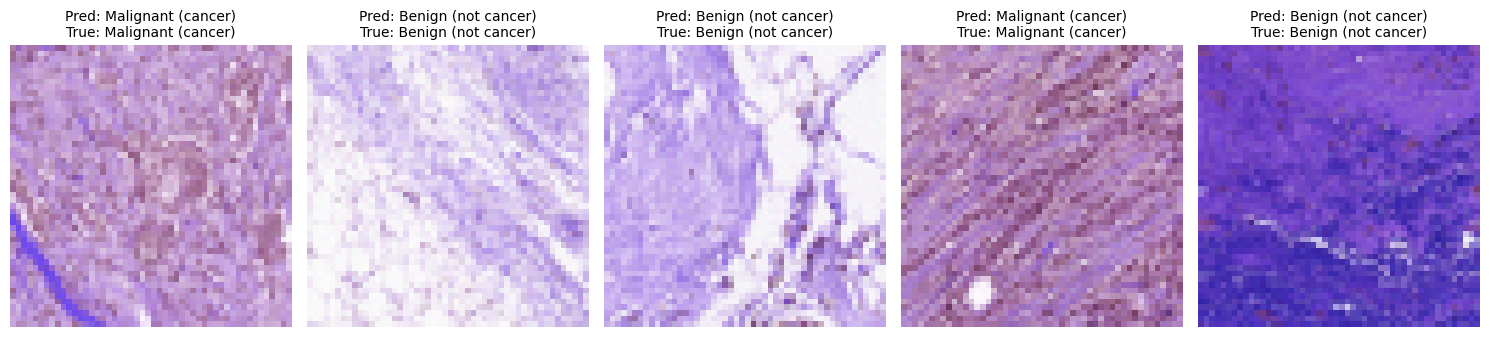

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Les noms des classes (à adapter selon ton dataset)
class_names = ['Benign (not cancer)', 'Malignant (cancer)']

# Nombre d'images à afficher
num_images = 5

plt.figure(figsize=(15, 5))

# Prendre tous les X_test et Y_test depuis le DataLoader
X_test_np = []
Y_test_np = []
for X_batch, y_batch in test_loader:
    X_test_np.append(X_batch)
    Y_test_np.append(y_batch)
X_test_np = torch.cat(X_test_np, dim=0).cpu().numpy()  # (N, C, H, W)
Y_test_np = torch.cat(Y_test_np, dim=0).cpu().numpy()  # (N,)

# Affichage de num_images images aléatoires
for i in range(num_images):
    index = np.random.randint(0, X_test_np.shape[0])

    image = X_test_np[index]               # (C, H, W)
    true_label = Y_test_np[index]          # int

    # Remettre l'image en (H, W, C) pour imshow, normaliser [0,1] si besoin
    img_disp = np.transpose(image, (1, 2, 0))
    img_disp = np.clip(img_disp / img_disp.max(), 0, 1)  # Optionnel selon preprocessing

    # Prédiction PyTorch
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(image).unsqueeze(0).to(device).float()  # (1, C, H, W)
        output = model(input_tensor)
        predicted_label = torch.argmax(output, 1).item()

    plt.subplot(1, num_images, i + 1)
    plt.imshow(img_disp)
    plt.title(f"Pred: {class_names[predicted_label]}\nTrue: {class_names[true_label]}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()
